In [ ]:
import argparse
import torch
import sys
sys.path.append('..')


from models.ECloudDecipher.models.io.coati import load_e3gnn_smiles_clip_e2e
from models.ECloudDecipher.models.regression.basic_due import basic_due
from models.ECloudDecipher.utils.chem import read_sdf, write_sdf, rm_radical, sa, qed, logp
from rdkit import Chem
import random
from models.ECloudDecipher.generative.molopt import gradient_opt
from models.ECloudDecipher.generative.coati_purifications import embed_smiles
from functools import partial
from torch.nn.functional import sigmoid
import torch.nn.functional as F
import numpy as np
from models.ECloudDecipher.generative.coati_purifications import force_decode_valid_batch, embed_smiles, force_decode_valid
import os.path as osp
from models.ECloudDecipher.optimize.scoring import ScoringFunction
from models.ECloudDecipher.optimize.mol_functions import qed_score, substructure_match_score, penalize_macrocycles, heavy_atom_count, penalized_logp_score
from models.ECloudDecipher.optimize.pso_optimizer import BasePSOptimizer
from models.ECloudDecipher.optimize.swarm import Swarm
from models.ECloudDecipher.optimize.rules.qsar_score import qsar_model


arg_parser = argparse.ArgumentParser(description='molecular optimization on the chemical space')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--ecloudgen_ckpt', type=str, default = '../model_ckpts/ecloud_smiles_67.pkl')
args = arg_parser.parse_args([])

In [2]:
# model loading
DEVICE = torch.device(args.device)
DEVICE = 'cuda:0'
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.ecloudgen_ckpt,
)

Loading model from ../model_ckpts/ecloud_smiles_67.pkl
Loading tokenizer mar from ../model_ckpts/ecloud_smiles_67.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [ ]:
class EPSO_format_model():
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def seq_to_emb(self, smiles):
        if isinstance(smiles, str):
            smi_emb = embed_smiles(smiles, self.model, self.tokenizer).to(DEVICE)
            return smi_emb
        else:
            emb_list = []
            for smi in smiles:
                smi_emb = embed_smiles(smi, self.model, self.tokenizer).to(DEVICE)
                emb_list.append(smi_emb)
            return torch.stack(emb_list).reshape(-1, 256)

    
    def emb_to_seq(self, embs):

        seq_list = []
        for emb in embs:
            seq = force_decode_valid_batch(emb, self.model, self.tokenizer)
            seq_list.append(seq)
        return seq_list

In [ ]:
ecloud_latent = EPSO_format_model(encoder, tokenizer, DEVICE)
scoring_functions = [ScoringFunction(func=qed_score, name="qed", is_mol_func=True)] 
# scoring_functions = [ScoringFunction(func=penalized_logp_score, name="plogp", is_mol_func=True, truncate_left=False, truncate_right=False)] 
init_smiles = "c1ccccc1"
pso_opt = BasePSOptimizer.from_query(
    init_smiles=init_smiles,
    num_part=200,
    num_swarms=1,
    inference_model=ecloud_latent,
    scoring_functions=scoring_functions,
    x_min=-5., 
    x_max=5.,
    device=DEVICE)

In [16]:
pso_opt.run(num_steps=5, num_track=100)

Particle Swarm Optimization...
Step 0, max: 0.443, min: 0.443, mean: 0.443
Step 1, max: 0.941, min: 0.780, mean: 0.844
Step 2, max: 0.947, min: 0.871, mean: 0.908
Step 3, max: 0.947, min: 0.897, mean: 0.921
Step 4, max: 0.947, min: 0.908, mean: 0.925
Particle Swarm Optimization finished.
You can access the best solutions with the self.best_solutions and self.best_fitness_history.


[mso.swarm.Swarm num_part=200 best_fitness=0.9474754333496094]

/home/odinz/.conda/envs/af3_repo/envs/ecloudgen/lib/python3.12/site-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


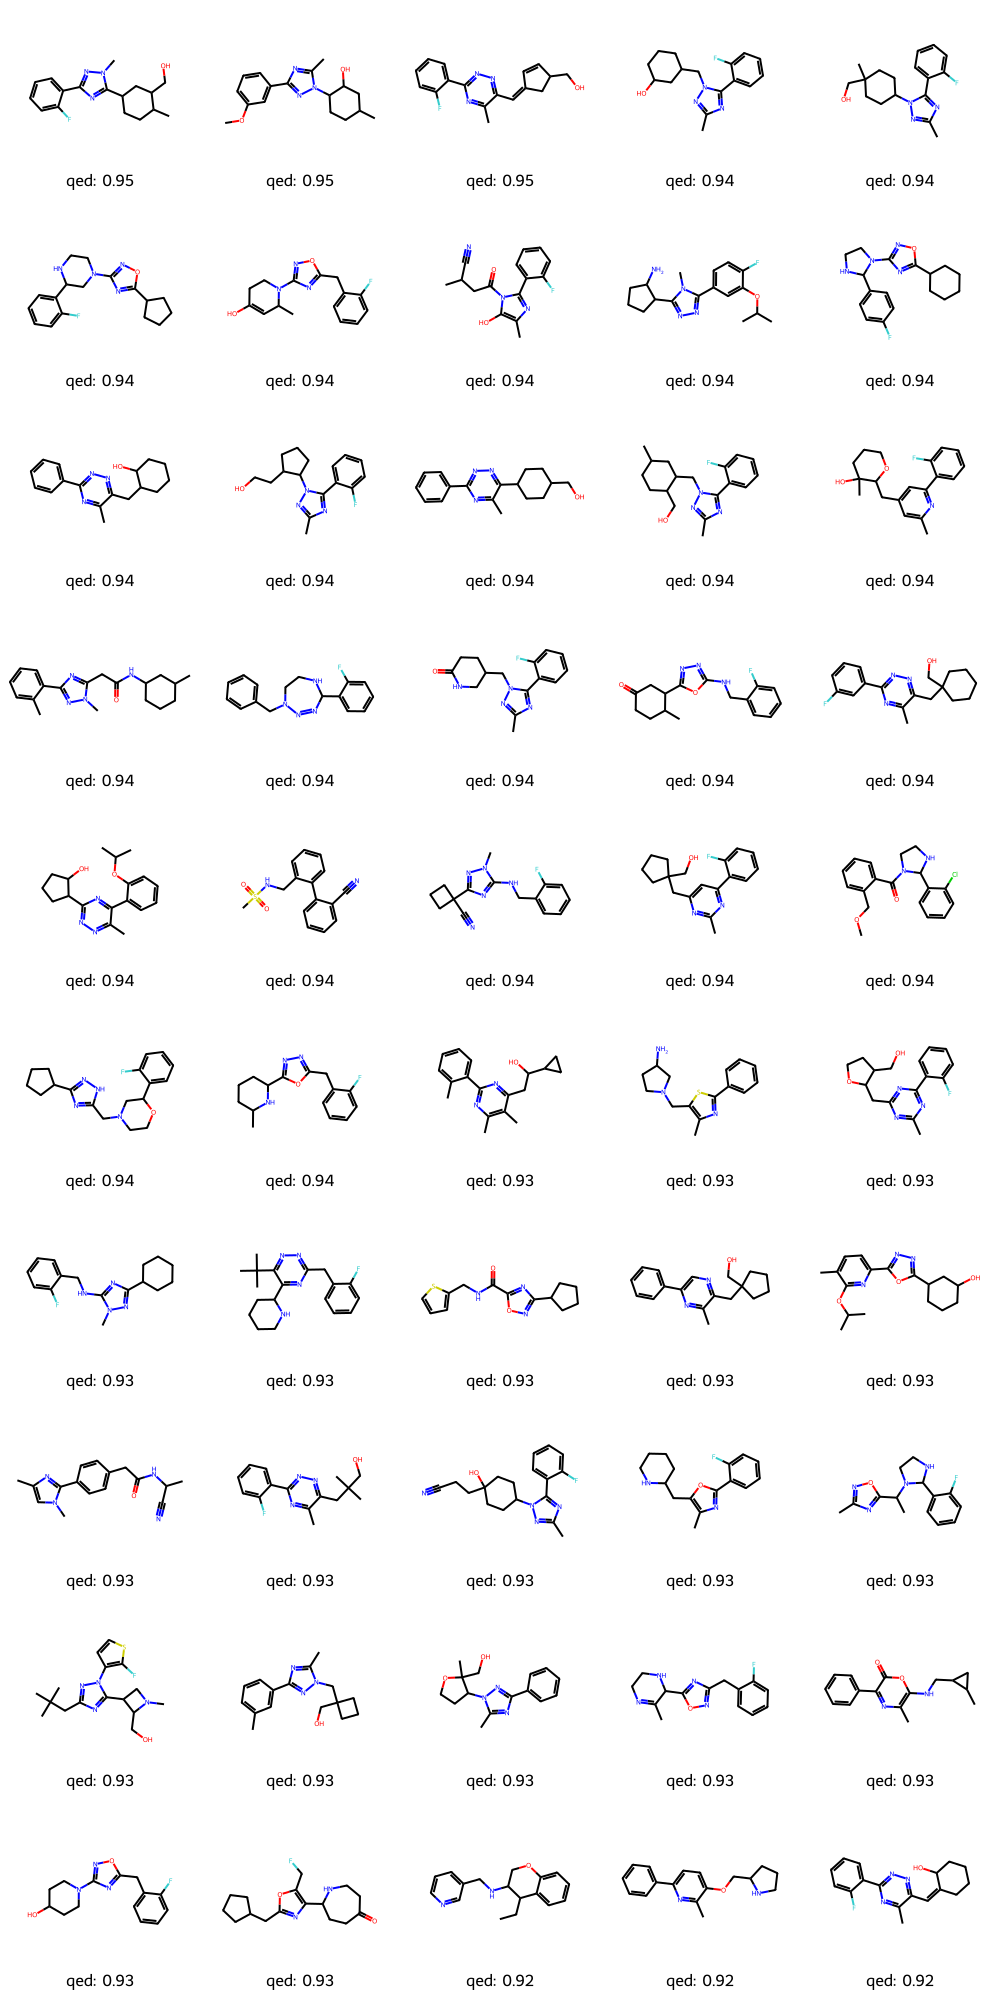

In [17]:
from rdkit.Chem import Draw
opt_smiles = pso_opt.best_solutions['smiles'].to_list()
opt_fitness = pso_opt.best_solutions['fitness'].to_list()
opt_mols = [Chem.MolFromSmiles(smi) for smi in opt_smiles]
qed_scores = [qed_score(mol) for mol in opt_mols]
Draw.MolsToGridImage(opt_mols, molsPerRow=5, legends=[f"qed: {f:.2f}" for f in qed_scores])